Definicja systemu wraz z funkcją obliczającą odległość cykliczną

In [29]:
import numpy as np

np.random.seed(0)



# Parametry systemu QC-MDPC

N = 997  # długość bloku cyklicznego

w = 15   # waga Hamminga klucza

t = 15   # waga błędu



def get_cyclic_distances(vector: np.ndarray, N: int):

    """Zwraca listę odległości cyklicznych między jedynkami w wektorze binarnym."""

    ones = np.flatnonzero(vector)

    distances = []

    for i in range(len(ones)):

        for j in range(i + 1, len(ones)):

            diff = abs(int(ones[i]) - int(ones[j]))

            dist = min(diff, N - diff)

            if dist != 0:

                distances.append(dist)

    return distances


 1. Funkcja `generate_key(N, w)`: zwraca losowy wektor binarny (h0) o długości N i wadze w.
 2. Funkcja `syndrome_decoding(h0, error_vector, N, max_iter=20)`:
    - Symuluje prosty algorytm Bit-Flipping.
    - Oblicza syndrom s = h0 * error_vector (splot cykliczny).
    - W pętli: oblicza liczbę niezadowolonych równań parzystości dla każdego bitu.
    - Jeśli liczba niezadowolonych równań > threshold (np. max_unsat - delta), odwraca bit.
    - Jeśli syndrom jest zerowy -> sukces (zwraca True).
    - Jeśli po max_iter syndrom nadal nie jest zerowy -> porażka (zwraca False).



In [30]:
def generate_key(N: int, w: int) -> np.ndarray:

    """Generuje losowy wektor binarny o zadanej wadze."""

    key = np.zeros(N, dtype=int)

    positions = np.random.choice(N, size=w, replace=False)

    key[positions] = 1

    return key





def syndrome_decoding(h0: np.ndarray, error_vector: np.ndarray, N: int, max_iter: int = 8):

    """Prosty algorytm Bit-Flipping; zwraca True jeśli dekodowanie się powiodło."""



    def compute_syndrome(h: np.ndarray, e: np.ndarray) -> np.ndarray:

        syndrome = np.zeros(N, dtype=int)

        for idx in np.flatnonzero(e):

            syndrome ^= np.roll(h, idx)

        return syndrome % 2



    error = error_vector.copy()

    syndrome = compute_syndrome(h0, error)

    if not syndrome.any():

        return True



    for _ in range(max_iter):

        unsat = np.zeros(N, dtype=int)

        for shift, val in enumerate(h0):

            if val:

                unsat += np.roll(syndrome, -shift)

        max_unsat = int(unsat.max())

        threshold = max_unsat - 1

        flips = unsat > threshold

        if flips.any():

            error[flips] ^= 1

            syndrome = compute_syndrome(h0, error)

            if not syndrome.any():

                return True

        else:

            break



    return not syndrome.any()


secret_key = generate_key(N, w)

atak GJS (Guo-Johansson-Stankovski) - Reaction Attack do znajdywania widma odległości.


Algorytm:
 1. Ustaw licznik prób `num_trial`.
 2. Stwórz pustą tablicę/słownik do zliczania wystąpień odległości w błędnych wektorach (`spectrum_candidates`).
 3. W pętli `num_trials`:
    - Wygeneruj losowy wektor błędu `e` o wadze `t`.
    - Uruchom `syndrome_decoding(secret_key, e, N)`.
    - Jeśli dekodowanie ZWRÓCIŁO FAŁSZ (Decoding Failure):
        - Oblicz odległości cykliczne w wektorze `e` (użyj funkcji z kroku 1).
        - Zaktualizuj licznik `spectrum_candidates` tymi odległościami.

 Wyświetl ile błędów dekodowania udało się złapać (Decoding Failure Rate).

In [31]:
num_trials = 100000

spectrum_candidates = {}

failures = 0



for _ in range(num_trials):

    print(f"Trial {_ + 1}/{num_trials}", end='\r')

    error_vector = np.zeros(N, dtype=int)

    error_positions = np.random.choice(N, size=t, replace=False)

    error_vector[error_positions] = 1

    success = syndrome_decoding(secret_key, error_vector, N)

    if not success:
        print(f"Decoding failed on trial {_ + 1}")

        failures += 1

        dists = get_cyclic_distances(error_vector, N)

        for d in dists:

            spectrum_candidates[d] = spectrum_candidates.get(d, 0) + 1



failure_rate = failures / num_trials

print(f"Decoding failures: {failures}/{num_trials} ({failure_rate:.4f})")

Decoding failed on trial 6
Decoding failed on trial 9
Decoding failed on trial 17
Decoding failed on trial 20
Decoding failed on trial 24
Decoding failed on trial 38
Decoding failed on trial 43
Decoding failed on trial 51
Decoding failed on trial 53
Decoding failed on trial 62
Decoding failed on trial 68
Decoding failed on trial 70
Decoding failed on trial 88
Decoding failed on trial 112
Decoding failed on trial 115
Decoding failed on trial 119
Decoding failed on trial 121
Decoding failed on trial 130
Decoding failed on trial 131
Decoding failed on trial 137
Decoding failed on trial 154
Decoding failed on trial 163
Decoding failed on trial 166
Decoding failed on trial 167
Decoding failed on trial 176
Decoding failed on trial 177
Decoding failed on trial 181
Decoding failed on trial 190
Decoding failed on trial 191
Decoding failed on trial 202
Decoding failed on trial 215
Decoding failed on trial 216
Decoding failed on trial 218
Decoding failed on trial 219
Decoding failed on trial 228



Wizualizacja wyników ataku
 1. Oblicz PRAWDZIWE widmo odległości dla `secret_key` (to jest nasz Ground Truth).
 2. Wykres
    - Oś X: Odległości (od 1 do N//2).
    - Oś Y: Liczba wystąpień danej odległości w wektorach, które spowodowały błąd dekodowania.

- Niebieskie słupki: Sukcesy: szum przez brak policzenia dokładnej odległości
- Czerwone słupki: Porażki, powinny być wyższe od niebieskich

Total distance observations: 1290660
Threshold (1%): 12906
True distances in key: [14, 18, 24, 25, 30, 38, 42, 48, 52, 61, 68, 70, 72, 77, 80, 83, 86, 91, 92, 94, 108, 110, 121, 131, 135, 140, 146, 147, 148, 156, 160, 162, 169, 171, 172, 186, 190, 204, 207, 217, 220, 221, 224, 234, 238, 239, 248, 262, 263, 277, 278, 281, 291, 292, 294, 296, 300, 303, 308, 310, 311, 318, 320, 330, 334, 348, 355, 369, 372, 380, 383, 386, 388, 394, 402, 408, 410, 413, 424, 428, 431, 438, 440, 449, 455, 456, 458, 463, 468, 469, 474, 477, 480, 482, 496, 498]


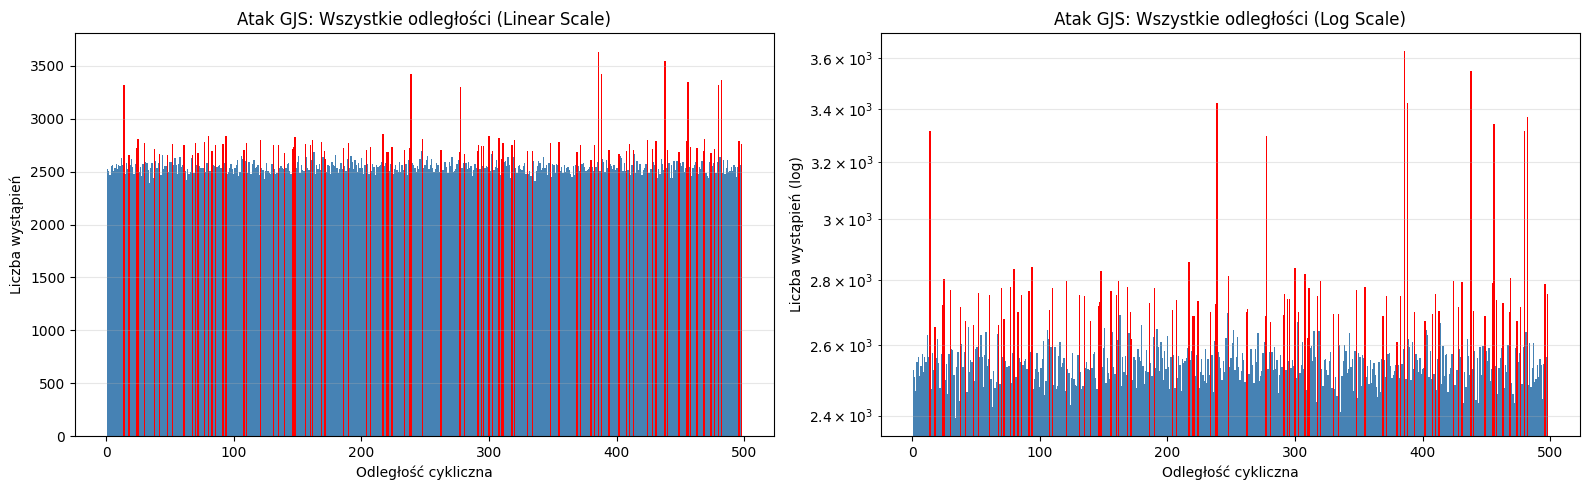


=== ANALIZA RED SPIKE'ÓW ===
Distance 14: 3316 (0.26%) ✗
Distance 18: 2654 (0.21%) ✗
Distance 24: 2721 (0.21%) ✗
Distance 25: 2804 (0.22%) ✗
Distance 30: 2768 (0.21%) ✗
Distance 38: 2715 (0.21%) ✗
Distance 42: 2671 (0.21%) ✗
Distance 48: 2661 (0.21%) ✗
Distance 52: 2760 (0.21%) ✗
Distance 61: 2752 (0.21%) ✗
Distance 68: 2661 (0.21%) ✗
Distance 70: 2775 (0.22%) ✗
Distance 72: 2679 (0.21%) ✗
Distance 77: 2776 (0.22%) ✗
Distance 80: 2835 (0.22%) ✗
Distance 83: 2699 (0.21%) ✗
Distance 86: 2753 (0.21%) ✗
Distance 91: 2765 (0.21%) ✗
Distance 92: 2765 (0.21%) ✗
Distance 94: 2841 (0.22%) ✗
Distance 108: 2707 (0.21%) ✗
Distance 110: 2775 (0.22%) ✗
Distance 121: 2798 (0.22%) ✗
Distance 131: 2751 (0.21%) ✗
Distance 135: 2750 (0.21%) ✗
Distance 140: 2673 (0.21%) ✗
Distance 146: 2718 (0.21%) ✗
Distance 147: 2731 (0.21%) ✗
Distance 148: 2829 (0.22%) ✗
Distance 156: 2765 (0.21%) ✗
Distance 160: 2751 (0.21%) ✗
Distance 162: 2797 (0.22%) ✗
Distance 169: 2778 (0.22%) ✗
Distance 171: 2699 (0.21%) ✗
Dist

In [32]:
import matplotlib.pyplot as plt



true_distances = get_cyclic_distances(secret_key, N)

true_distance_set = set(true_distances)



max_dist = N // 2

x_vals = np.arange(1, max_dist + 1)

y_vals = np.array([spectrum_candidates.get(int(d), 0) for d in x_vals], dtype=int)

colors = ["red" if dist in true_distance_set else "steelblue" for dist in x_vals]



# Oblicz threshold - pokazuj tylko odległości powyżej 1% wszystkich obserwacji
total_observations = sum(spectrum_candidates.values())
threshold_count = max(1, total_observations // 100)  # 1% threshold

print(f"Total distance observations: {total_observations}")
print(f"Threshold (1%): {threshold_count}")
print(f"True distances in key: {sorted(true_distance_set)}")



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))



# Wykres 1: Wszystkie dane (linear scale)
ax1.bar(x_vals, y_vals, color=colors, width=1.0)

ax1.set_title("Atak GJS: Wszystkie odległości (Linear Scale)")

ax1.set_xlabel("Odległość cykliczna")

ax1.set_ylabel("Liczba wystąpień")

ax1.grid(axis='y', alpha=0.3)



# Wykres 2: Log scale (lepiej widać spike'i)
y_vals_log = np.where(y_vals > 0, y_vals, 0.1)  # Zamiana 0 na 0.1 dla log scale

ax2.bar(x_vals, y_vals_log, color=colors, width=1.0)

ax2.set_yscale('log')

ax2.set_title("Atak GJS: Wszystkie odległości (Log Scale)")

ax2.set_xlabel("Odległość cykliczna")

ax2.set_ylabel("Liczba wystąpień (log)")

ax2.grid(axis='y', alpha=0.3, which='both')



plt.tight_layout()

plt.show()



# Analiza: pokaż które RED są powyżej threshold'u
print("\n=== ANALIZA RED SPIKE'ÓW ===")
for dist in sorted(true_distance_set):
    count = spectrum_candidates.get(dist, 0)
    ratio = (count / total_observations * 100) if total_observations > 0 else 0
    marker = "✓" if count > threshold_count else "✗"
    print(f"Distance {dist}: {count} ({ratio:.2f}%) {marker}")